# Exploratory Data Analysis

- [Accéder aux bases](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/)
- [Accéder à la documentation](https://www.data.gouv.fr/fr/datasets/r/8ef4c2a3-91a0-4d98-ae3a-989bde87b62a)

# Objectifs : prédire la gravité d'un accident

La gravité d'un accident est codée par la variable `grav`, présente (uniquement) dans la base _usagers_, qui peut prendre les valeurs suivantes :
- 1 : indemne ;
- 2 : tué ;
- 3 : blessé hospitalisé ;
- 4 : blessé léger.

On charge dans un premier temps tous les packages nécessaires.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Sur data.gouv, quatre bases de données sont publiées annuellement. Elles concernent : les usages, les véhicules, les lieux et les caractéristiques. Nous chargeons ci-dessous les quatre bases de 2021 (les plus récentes).

In [2]:
df_usagers_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/62c20524-d442-46f5-bfd8-982c59763ec8", sep=";")
df_vehicules_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/c9742921-4427-41e5-81bc-f13af8bc31a0", sep=";")
df_lieux_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a6ef711a-1f03-44cb-921a-0ce8ec975995", sep=";")
df_caracs_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/5fc299c0-4598-4c29-b74c-6a67b0cc27e7", sep=";")

df_usagers_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/ba5a1956-7e82-41b7-a602-89d7dd484d7a", sep=";")
df_vehicules_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0bb5953a-25d8-46f8-8c25-b5c2f5ba905e", sep=";")
df_lieux_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8a4935aa-38cd-43af-bf10-0209d6d17434", sep=";")
df_caracs_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/85cfdc0c-23e4-4674-9bcd-79a970d7269b", sep=";")

df_usagers_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/78c45763-d170-4d51-a881-e3147802d7ee", sep=";")
df_vehicules_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a66be22f-c346-49af-b196-71df24702250", sep=";")
df_lieux_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/e85c41f7-d4ea-4faf-877f-ab69a620ce21", sep=";")
df_caracs_20 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/07a88205-83c1-4123-a993-cba5331e8ae0", sep=";")

df_usagers_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/36b1b7b3-84b4-4901-9163-59ae8a9e3028", sep=";")
df_vehicules_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/780cd335-5048-4bd6-a841-105b44eb2667", sep=";")
df_lieux_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/2ad65965-36a1-4452-9c08-61a6c874e3e6", sep=";")
df_caracs_19 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/e22ba475-45a3-46ac-a0f7-9ca9ed1e283a", sep=";")

c:\Users\nahta\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
from data_cleaning import *

In [4]:
df_usagers_22 = clean_df_usagers(df_usagers_22)
df_vehicules_22 = clean_df_vehicules(df_vehicules_22)
df_lieux_22 = clean_df_lieux(df_lieux_22)
df_caracs_22 = clean_df_caracs(df_caracs_22)

df_usagers_21 = clean_df_usagers(df_usagers_21)
df_vehicules_21 = clean_df_vehicules(df_vehicules_21)
df_lieux_21 = clean_df_lieux(df_lieux_21)
df_caracs_21 = clean_df_caracs(df_caracs_21)

df_usagers_20 = clean_df_usagers(df_usagers_20)
df_vehicules_20 = clean_df_vehicules(df_vehicules_20)
df_lieux_20 = clean_df_lieux(df_lieux_20)
df_caracs_20 = clean_df_caracs(df_caracs_20)

df_usagers_19 = clean_df_usagers(df_usagers_19)
df_vehicules_19 = clean_df_vehicules(df_vehicules_19)
df_lieux_19 = clean_df_lieux(df_lieux_19)
df_caracs_19 = clean_df_caracs(df_caracs_19)

# Jointure

On s'assure qu'on a bien autant d'observations dont le triplet `(Num_Acc, id_vehicule, num_veh)` est unique dans les bases `usagers` et `véhicules`.

In [5]:
(~df_usagers_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

In [6]:
(~df_vehicules_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

À présent, on peut procéder à la jointure à l'aide de `pd.merge`. On joint d'abord les bases `usagers` et `vehicules` sur `(Num_Acc, id_vehicule, num_veh)`, puis on joint également les bases `lieux` et `caracs` sur l'identifiant de l'accident, codé par `Num_Acc`.

In [7]:
df_merged_22 = pd.merge(pd.merge(pd.merge(df_usagers_22, df_vehicules_22, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_22, on="Num_Acc"), df_caracs_22, on="Num_Acc")

In [8]:
len(df_merged_22)

126662

On retombe bien sur un total de 126 662 observations, soit la longueur de la base usagers.

On fait de même pour les autres années (2021).

In [9]:
df_merged_21 = pd.merge(pd.merge(pd.merge(df_usagers_21, df_vehicules_21, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_21, on="Num_Acc"), df_caracs_21, on="Num_Acc")

df_merged_20 = pd.merge(pd.merge(pd.merge(df_usagers_20, df_vehicules_20, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_20, on="Num_Acc"), df_caracs_20, on="Num_Acc")

df_merged_19 = pd.merge(pd.merge(pd.merge(df_usagers_19, df_vehicules_19, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_19, on="Num_Acc"), df_caracs_19, on="Num_Acc")

In [10]:
df_merged = pd.concat([df_merged_22, df_merged_21, df_merged_20, df_merged_19], ignore_index=True)

In [11]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494182 entries, 0 to 494181
Data columns (total 56 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      494182 non-null  int64  
 1   id_usager    255910 non-null  object 
 2   id_vehicule  494182 non-null  object 
 3   num_veh      494182 non-null  object 
 4   place        494157 non-null  float64
 5   catu         494182 non-null  object 
 6   grav         493881 non-null  float64
 7   sexe         488376 non-null  object 
 8   an_nais      488241 non-null  float64
 9   trajet       360809 non-null  object 
 10  secu1        388294 non-null  object 
 11  secu2        59943 non-null   object 
 12  secu3        4029 non-null    object 
 13  locp         277429 non-null  float64
 14  actp         222449 non-null  object 
 15  etatp        37936 non-null   object 
 16  senc         492526 non-null  float64
 17  catv         493108 non-null  float64
 18  obs          493991 non-

# Nettoyages

On élimine l'unique `NaN` de la variable `grav`.

In [12]:
df_merged.dropna(subset=['grav'], inplace=True)

In [13]:
for equipement in ["ceinture", "casque", "dispositif enfants", "gilet réfléchissant",
                   "airbag", "gants", "gants + airbag", "autre"]:
    df_merged[equipement] = df_merged[["secu1", "secu2", "secu3"]].isin([equipement]).any(axis=1)

df_merged["airbag"] = df_merged["airbag"] | df_merged["gants + airbag"]
df_merged["gants"] = df_merged["gants"] | df_merged["gants + airbag"]
df_merged.drop("gants + airbag", axis=1, inplace=True)

In [14]:
df_merged.replace(-1, np.nan, inplace=True)
df_merged.replace("-1", np.nan, inplace=True)
df_merged.replace(" -1", np.nan, inplace=True)

In [15]:
df_merged["grav"].replace({2: 4, 4: 2}, inplace=True)

In [16]:
df_merged.columns

Index(['Num_Acc', 'id_usager', 'id_vehicule', 'num_veh', 'place', 'catu',
       'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2', 'secu3', 'locp',
       'actp', 'etatp', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor',
       'occutc', 'catr', 'voie', 'v1', 'v2', 'circ', 'nbv', 'vosp', 'prof',
       'pr', 'pr1', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ',
       'vma', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg', 'int',
       'atm', 'col', 'adr', 'lat', 'long', 'heure', 'ceinture', 'casque',
       'dispositif enfants', 'gilet réfléchissant', 'airbag', 'gants',
       'autre'],
      dtype='object')

Eliminons d'emblée certaines variables qui ne serviront pas au modèle de prédiction de la gravité.

In [17]:
df_merged.drop(["Num_Acc", "id_usager", "id_vehicule", "num_veh", "voie", "v1", "v2",
                "dep", "com", "adr", "lat", "long", "pr", "pr1", "an"], axis=1, inplace=True)

On peut également enlever `lartpc` et `occutc` qui ont trop de `NaN`.

In [18]:
df_merged.drop(["lartpc", "occutc"], axis=1, inplace=True)

In [20]:
df_merged.columns

Index(['place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2',
       'secu3', 'locp', 'actp', 'etatp', 'senc', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'pr', 'pr1',
       'plan', 'larrout', 'surf', 'infra', 'situ', 'vma', 'jour', 'mois', 'an',
       'hrmn', 'lum', 'agg', 'int', 'atm', 'col', 'heure', 'ceinture',
       'casque', 'dispositif enfants', 'gilet réfléchissant', 'airbag',
       'gants', 'autre'],
      dtype='object')

Description des variables
- `place` : place occupée dans le véhicule par l'usager au moment de l'accident ; 1 conducteur, 10 piéton
- `sexe` : sexe de l'usager
- `an_nais` : année de naissance de l'usager
- `trajet` : motif du déplacement au moment de l'accident
- `secu` : présence et utilisation de tel équipement de sécurité
- `locp` : localisation du piéton
- `actp` : action du piéton
- `etatp` : piéton seul, accompagné ou en groupe
- `senc` : sens de circulation
- `catv` : catégorie du véhicule
- `obs` : obstacle fixe heurté
- `obsm` : obstacle mobile heurté
- `choc` : point de choc initial
- `manv` :
- `motor` :
- `catr` :
- `circ` :
- `nbv` :
- `vosp` :
- `prof` :
- `larrout` :
- `surf` :
- `infra` : 
- `situ` :
- `vma` :
- `jour` :
- `mois` :
- `hrmn` :
- `lum` :
- `agg` :
- `int` :
- `atm` :
- `col` :

In [35]:
df_merged['pr'].value_counts()

0       149597
(1)     117232
1        30541
2        11107
3         9371
         ...  
8246         1
2883         1
800          1
1015         1
5239         1
Name: pr, Length: 632, dtype: int64

# Statistiques descriptives

Petit truc qui sera utile pour la suite.

In [42]:
df_non_pieton = df_merged[df_merged["catu"]!="piéton"]
df_pieton = df_merged[df_merged["catu"]=="piéton"]


### `agg` [++]

On constate que
- la majorité des accidents de gravité 1 et 2 ont lieu en agglomération ;
- la majorité des accidents de gravité 3 et 4 ont lieu hors agglomération.


<AxesSubplot:xlabel='agg', ylabel='count'>

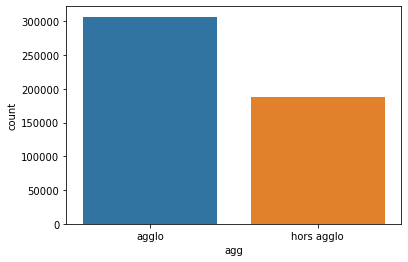

In [22]:
sns.countplot(data=df_merged, x="agg")

<AxesSubplot:xlabel='agg', ylabel='proportion'>

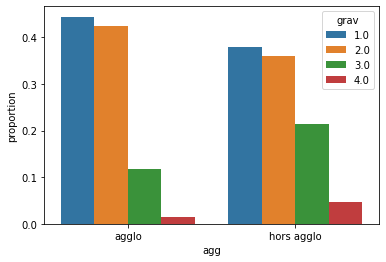

In [23]:
proportions = df_merged.groupby('agg')['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x='agg', y='proportion', hue='grav', data=proportions)

### `place` [-]

On utilisera plutôt la variable `catu`, car finalement les effectifs pour les différentes places sont très faibles.

<AxesSubplot:xlabel='place', ylabel='count'>

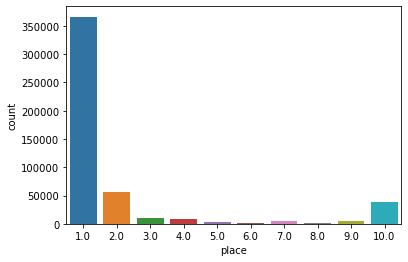

In [24]:
sns.countplot(data=df_merged, x="place")

<AxesSubplot:xlabel='place', ylabel='proportion'>

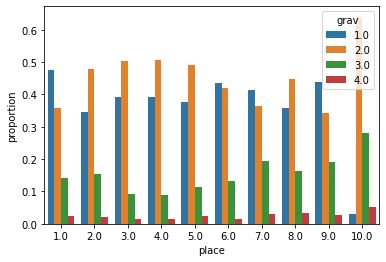

In [25]:
var = "place"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

### `catu` [+++]

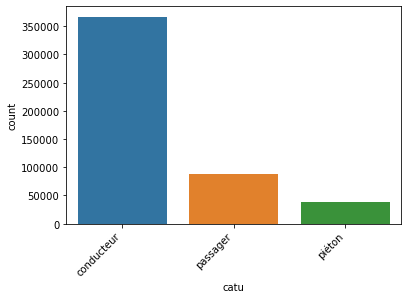

In [26]:
var = "catu"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

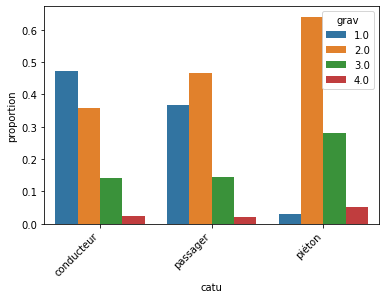

In [27]:
var = "catu"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `sexe` [++]

<AxesSubplot:xlabel='sexe', ylabel='count'>

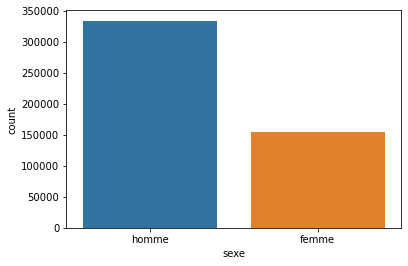

In [28]:
sns.countplot(data=df_merged, x="sexe")

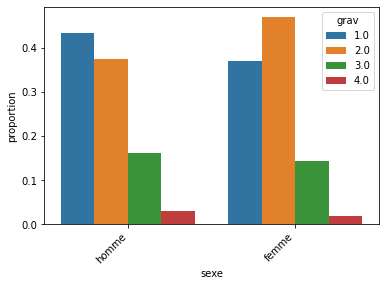

In [29]:
var = "sexe"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `an_nais` [+] (année de naissance)

<AxesSubplot:xlabel='an_nais', ylabel='Density'>

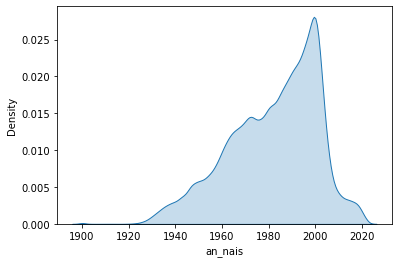

In [30]:
var = "an_nais"
sns.kdeplot(df_merged[var], fill=True)

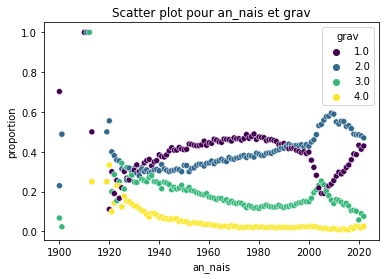

In [31]:
var = "an_nais"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.scatterplot(data=proportions, x=var, y='proportion', hue='grav', palette='viridis')
plt.title('Scatter plot pour an_nais et grav')
plt.show()

In [32]:
df_merged = df_merged[df_merged["an_nais"] >= 1930]

In [33]:
df_merged["ind_avant_1960"] = df_merged["an_nais"] < 1960
df_merged["ind_2002_2012"] = (df_merged["an_nais"] >= 2002) & (df_merged["an_nais"] <= 2012)

### `heure` [+, 2]

In [34]:
df_merged["heure"].value_counts()

18:00:00    6739
17:00:00    5895
17:30:00    5601
18:30:00    5537
19:00:00    5202
            ... 
04:41:00       3
04:24:00       3
03:36:00       3
03:59:00       2
03:31:00       2
Name: heure, Length: 1438, dtype: int64

In [35]:
df_merged["hrmn"]

0         16:15
1         16:15
2         08:34
3         08:34
4         17:15
          ...  
494177    07:50
494178    02:41
494179    15:20
494180    20:50
494181    20:50
Name: hrmn, Length: 486836, dtype: object

In [36]:
df_merged["heure"].apply(lambda x: x.hour)

0         16
1         16
2          8
3          8
4         17
          ..
494177     7
494178     2
494179    15
494180    20
494181    20
Name: heure, Length: 486836, dtype: int64

<AxesSubplot:xlabel='h', ylabel='Density'>

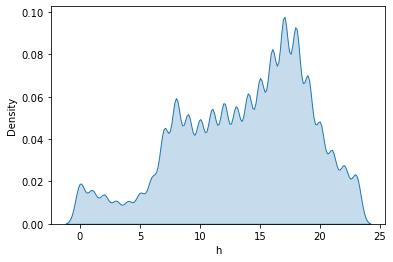

In [21]:
# df_merged["sec"] = df_merged["heure"].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
df_merged["h"] = df_merged["heure"]. apply(lambda x: x.hour)

sns.kdeplot(df_merged["h"], fill=True)

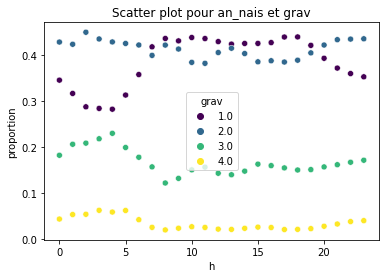

In [38]:
var = "h"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.scatterplot(data=proportions, x=var, y='proportion', hue='grav', palette='viridis')
plt.title('Scatter plot pour an_nais et grav')
plt.show()

In [39]:
df_merged["heure_2"] = np.where(df_merged["h"] < 7, 0,
                                np.where(df_merged["h"] >= 20, 1, 2))

### `nbv` [+, 2]

<AxesSubplot:xlabel='nbv', ylabel='count'>

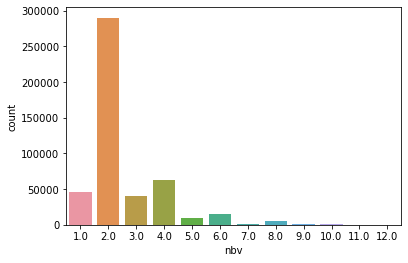

In [40]:
sns.countplot(data=df_merged, x="nbv")

<AxesSubplot:xlabel='nbv', ylabel='proportion'>

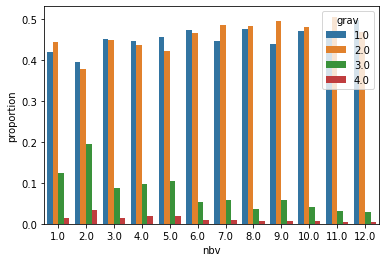

In [41]:
var = "nbv"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

In [42]:
df_merged["nbv_2"] = np.where(df_merged["nbv"].isin([2]), 0,
                              np.where(df_merged["nbv"].isin([1, 3, 4, 5]), 1, 2))

### `trajet` [+]

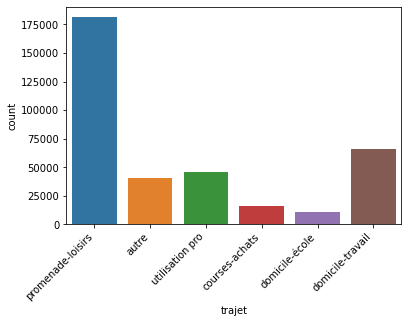

In [43]:
sns.countplot(data=df_merged, x="trajet")
plt.xticks(rotation=45, ha='right')
plt.show()

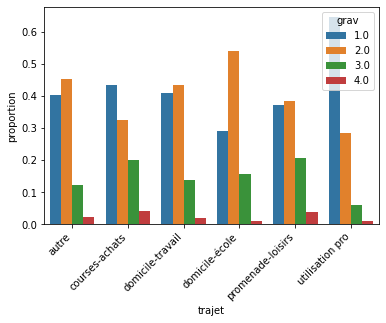

In [44]:
var = "trajet"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)
plt.xticks(rotation=45, ha='right')
plt.show()

### `lum` [+, 2]

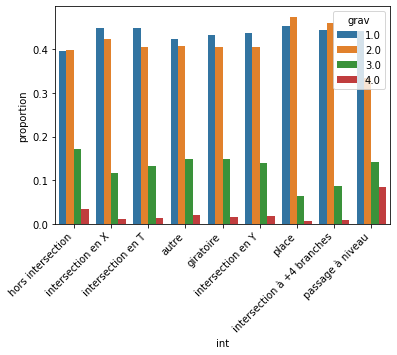

In [45]:
var = "int"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

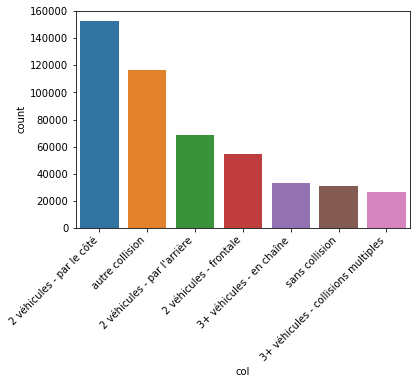

In [46]:
var = "col"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [47]:
df_merged["lum_2"] = np.where(df_merged["lum"].isin(["plein jour", "nuit avec éclairage public allumé"]), 1, 0)

### `surf` [-] (surface)

Il n'y a que 2 modalités aux effectifs importants, et leur profil de gravité est très similaire...

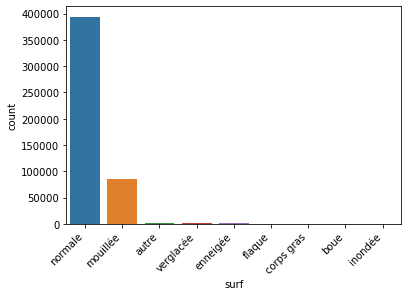

In [48]:
var = "surf"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

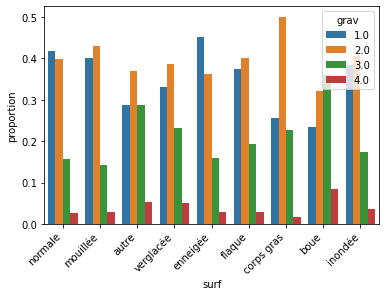

In [49]:
var = "surf"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `atm` [-] (conditions atmosphériques)

Les modalités dont les effectifs sont significatifs ont des profils de gravité trop similaires.

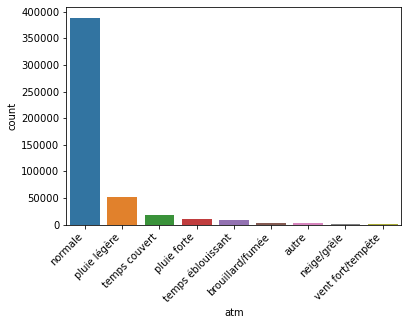

In [50]:
var = "atm"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

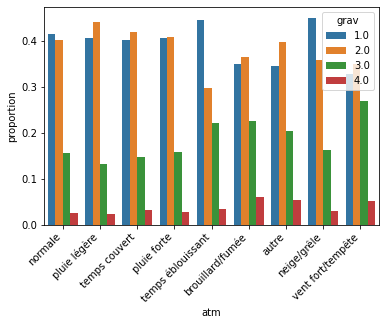

In [51]:
var = "atm"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `int` [-] (intersection)

Les modalités dont les effectifs sont significatifs ont des profils de gravité trop similaires.

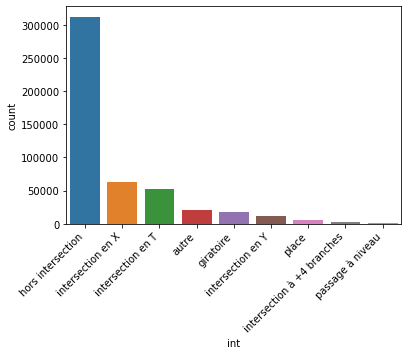

In [52]:
var = "int"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

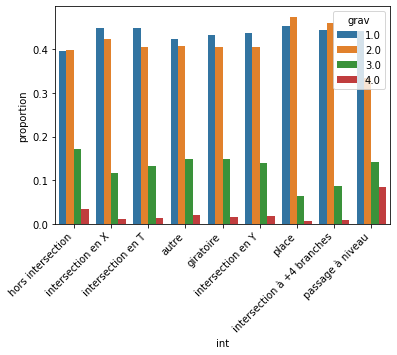

In [53]:
var = "int"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `col` [+, 2] (collision)

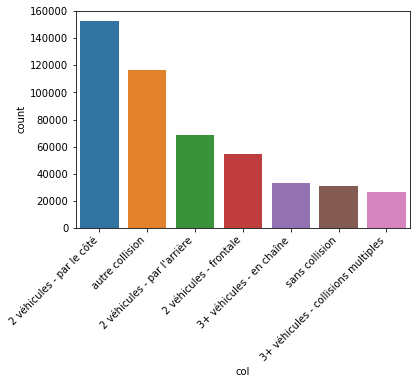

In [54]:
var = "col"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

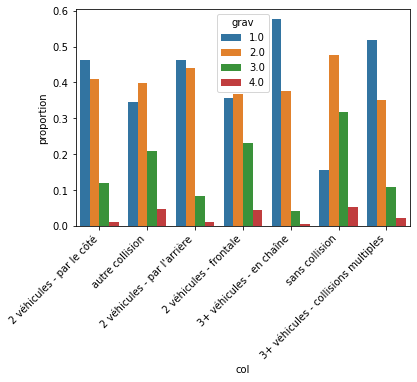

In [55]:
var = "col"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [56]:
df_merged["col_2"] = np.where(df_merged["col"].isin(["autre collision", "2 véhicules - frontale", "sans collision"]), 1, 0)

### `catr` [+, 2] (catégorie route)

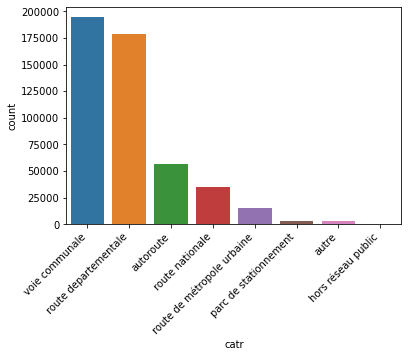

In [57]:
var = "catr"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

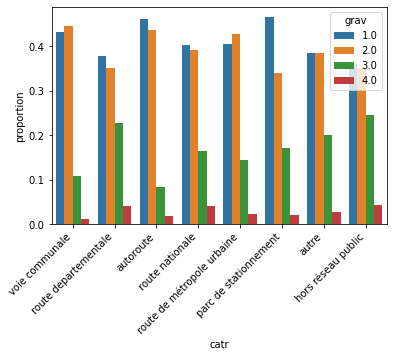

In [58]:
var = "catr"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [59]:
df_merged["catr_2"] = np.where(df_merged["catr"].isin(["route départementale", "hors réseau public"]), 0,
                               np.where(df_merged["catr"].isin(["route nationale", "route de métropole urbaine",
                                                               "parc de stationnement", "autre"]), 1, 2))

### `circ` [++] (régime de circulation)

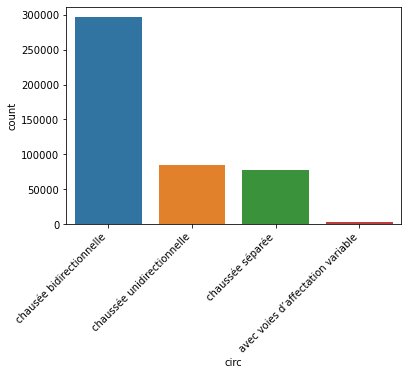

In [60]:
var = "circ"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

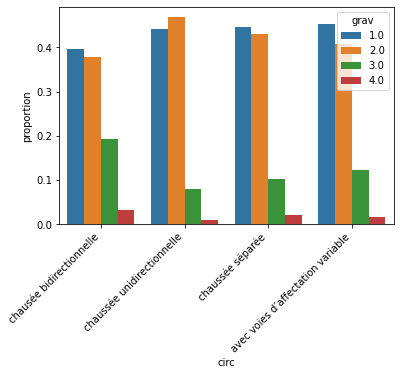

In [61]:
var = "circ"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `vosp` [-] (voie réservée)

Trop de `NaN` et profils de gravités trop similaires.

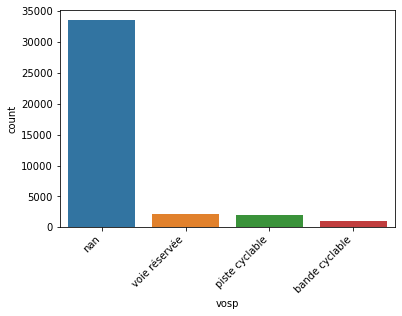

In [62]:
var = "vosp"
df_fill_na = df_pieton.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

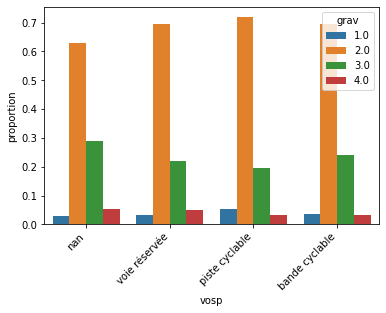

In [63]:
var = "vosp"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `prof` [-] (déclivité de la route)

Les modalités ont des profils de gravité trop similaires.

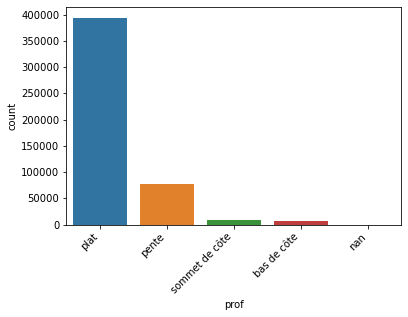

plat              394512
pente              76698
sommet de côte      8462
bas de côte         7086
nan                   78
Name: prof, dtype: int64

In [64]:
var = "prof"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

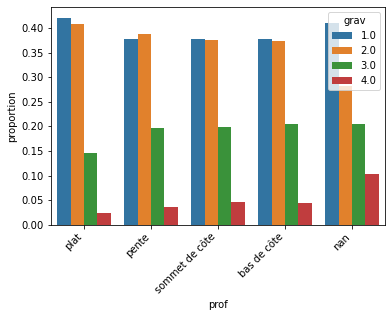

In [65]:
var = "prof"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `plan` [+, 2] (tracé en plan)

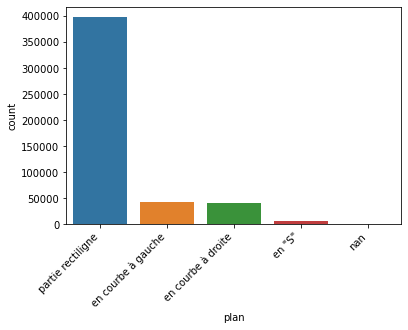

partie rectiligne     397907
en courbe à gauche     42301
en courbe à droite     40459
en "S"                  6109
nan                       60
Name: plan, dtype: int64

In [66]:
var = "plan"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

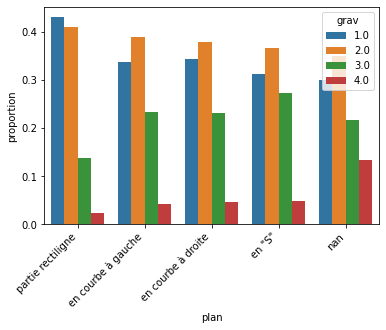

In [67]:
var = "plan"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [68]:
df_merged["plan_2"] = np.where(df_merged["plan"].isin(["partie rectiligne"]), 1, 0)

### `infra` [-] (aménagement, infrastructure)

Il y a _a priori_ trop peu de non `NaN` pour en tirer quelque chose d'intéressant, et de toute façon les profils de gravité sont assez similaires.

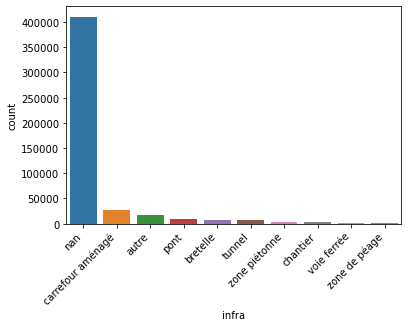

nan                  410498
carrefour aménagé     27761
autre                 16992
pont                   8845
bretelle               6748
tunnel                 6393
zone piétonne          3962
chantier               3739
voie ferrée            1531
zone de péage           367
Name: infra, dtype: int64

In [69]:
var = "infra"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

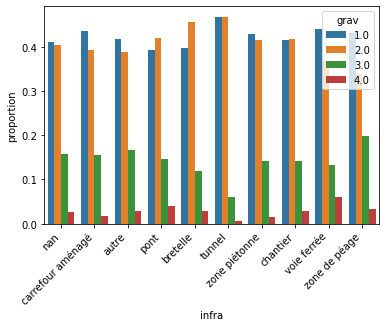

In [70]:
var = "infra"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `situ` [+, 2]

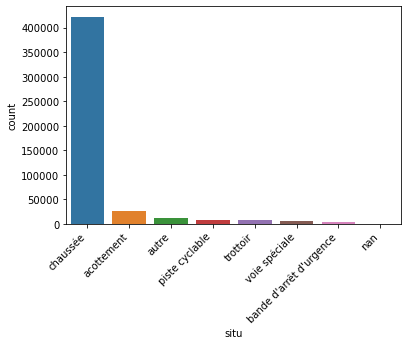

chaussée                   422258
acottement                  26228
autre                       12088
piste cyclable               8582
trottoir                     7585
voie spéciale                5542
bande d'arrêt d'urgence      4280
nan                           273
Name: situ, dtype: int64

In [71]:
var = "situ"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

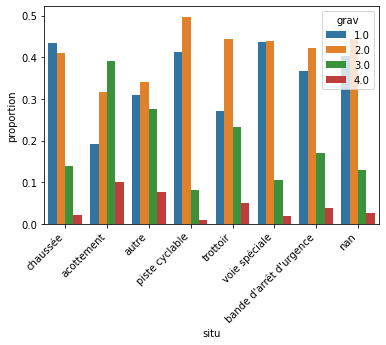

In [72]:
var = "situ"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [73]:
df_merged["situ_2"] = np.where(df_merged["situ"].isin(["acottement"]), 0, 
                               np.where(df_merged["situ"].isin(["autre", "trottoir"]), 1, 2))

### `obs` [-] (obstacle fixe heurté)

Pas très intéressant, quasi que des "sans objet" puisque ce sont essentiellement des obstacles mobiles.

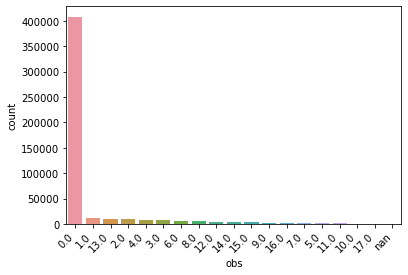

0.0     408028
1.0      11516
13.0     10077
2.0       8767
4.0       7491
3.0       7403
6.0       6573
8.0       6491
12.0      3809
14.0      3622
15.0      3301
9.0       2577
16.0      2223
7.0       1663
5.0        955
11.0       921
10.0       639
17.0       627
nan        153
Name: obs, dtype: int64

In [74]:
var = "obs"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

### `obsm` [+, 2] (type d'obstacle heurté)

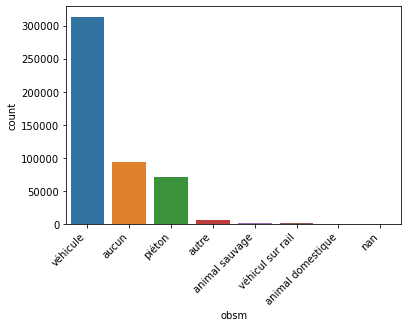

véhicule             313447
aucun                 94173
piéton                70616
autre                  6249
animal sauvage         1278
véhicul sur rail        473
animal domestique       377
nan                     223
Name: obsm, dtype: int64

In [75]:
var = "obsm"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

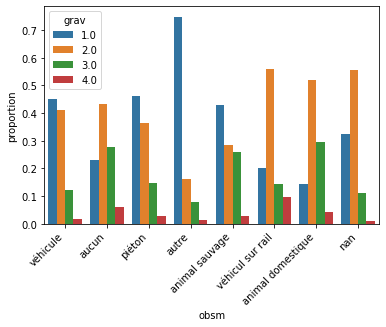

In [76]:
var = "obsm"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

In [77]:
df_merged["obsm_2"] = np.where(df_merged["obsm"].isin(["aucun"]), 0, 
                               np.where(df_merged["obsm"].isin(["autre"]), 1, 2))

### `choc` [+, 2 à venir]

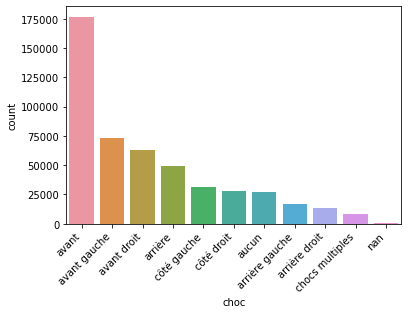

avant              176763
avant gauche        72826
avant droit         63136
arrière             48960
côté gauche         31623
côté droit          27892
aucun               26846
arrière gauche      16935
arrière droit       13517
chocs multiples      8146
nan                   192
Name: choc, dtype: int64

In [78]:
var = "choc"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

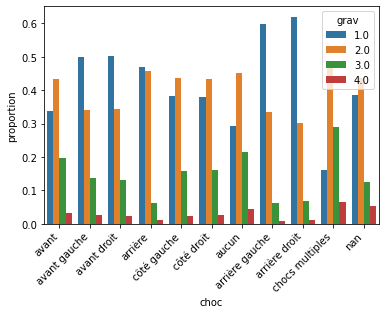

In [79]:
var = "choc"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `manv` [+, réfléchir]

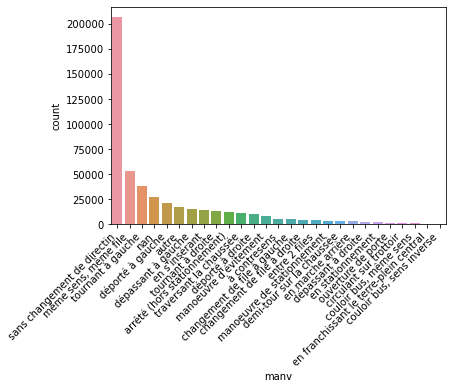

sans changement de directin               206884
même sens, même file                       53753
tournant à gauche                          38275
nan                                        26980
déporté à gauche                           21001
autre                                      17200
dépassant à gauche                         15712
en s'insérant                              13909
tournant à droite                          13104
arrêté (hors stationnement)                12429
traversant la chaussée                     11706
déporté à droite                           10551
manoeuvre d'évitement                       7859
à contresens                                4981
changement de file à gauche                 4971
changement de file à droite                 4414
entre 2 files                               4384
manoeuvre de stationnement                  3165
demi-tour sur la chaussée                   3063
en marche arrière                           3024
dépassant à droite  

In [80]:
var = "manv"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

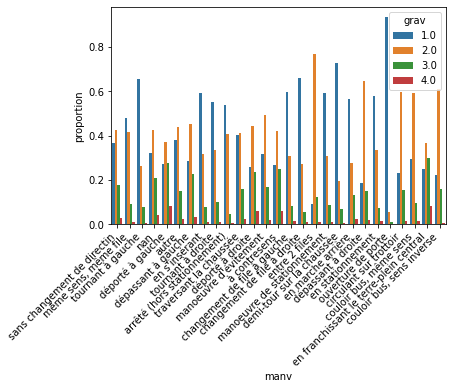

In [81]:
var = "manv"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `motor` [+, réfléchir] (motorisation du véhicule)

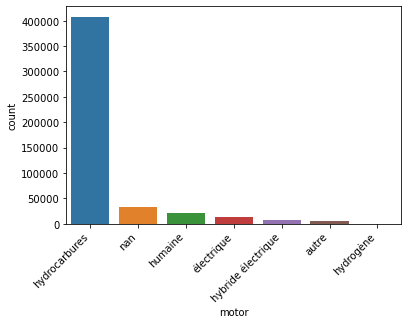

hydrocarbures         407859
nan                    32625
humaine                20717
électrique             13147
hybride électrique      7886
autre                   4304
hydrogène                298
Name: motor, dtype: int64

In [82]:
var = "motor"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

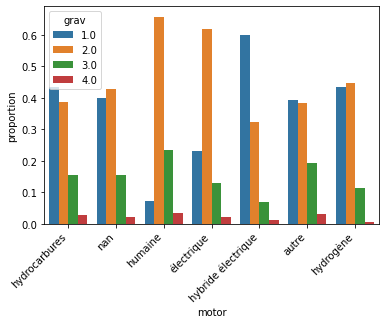

In [83]:
var = "motor"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `locp` [-] (localisation du piéton)

Les modalités dont les effectifs sont significatifs ont des profils de gravité trop similaires.

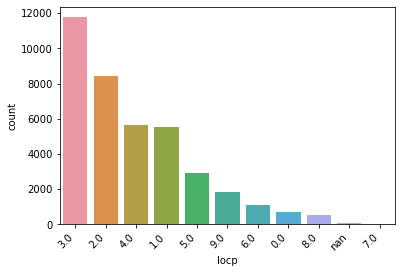

3.0    11762
2.0     8424
4.0     5671
1.0     5509
5.0     2924
9.0     1837
6.0     1108
0.0      688
8.0      544
nan       82
7.0       42
Name: locp, dtype: int64

In [84]:
var = "locp"
df_fill_na = df_pieton.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

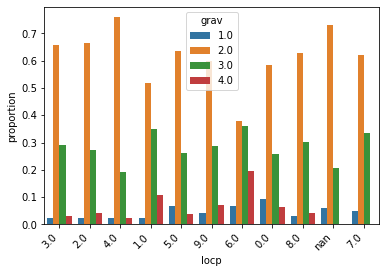

In [85]:
var = "locp"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `actp` [-] (action du piéton)

La variable est trop peu variée pour être intéressante à exploiter.

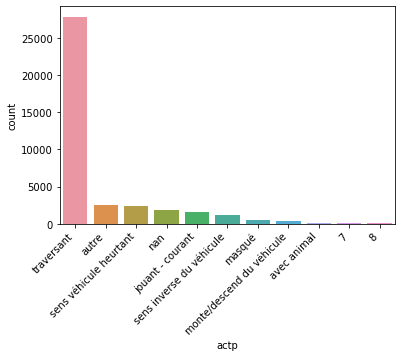

traversant                   27870
autre                         2523
sens véhicule heurtant        2440
nan                           1903
jouant - courant              1531
sens inverse du véhicule      1156
masqué                         529
monte/descend du véhicule      421
avec animal                    106
7                               60
8                               52
Name: actp, dtype: int64

In [86]:
var = "actp"
df_fill_na = df_pieton.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

### `etatp` [-]

Profils de gravité trop similaires.

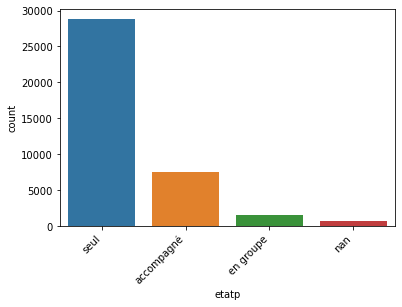

seul          28815
accompagné     7558
en groupe      1509
nan             709
Name: etatp, dtype: int64

In [87]:
var = "etatp"
df_fill_na = df_pieton.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

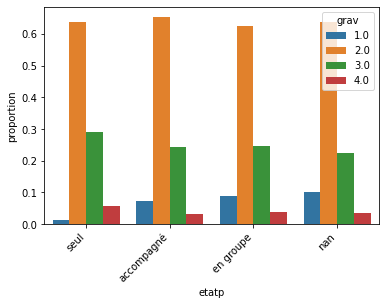

In [88]:
var = "etatp"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### `jour` [-]

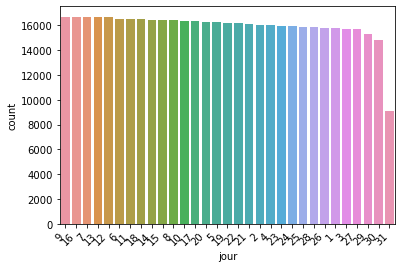

9     16699
16    16686
7     16676
13    16670
12    16645
6     16545
11    16495
18    16480
14    16464
15    16440
8     16398
10    16359
17    16314
20    16270
5     16264
19    16218
22    16199
21    16097
2     16061
4     16048
23    15932
24    15906
25    15865
28    15864
26    15804
1     15797
3     15727
27    15725
29    15329
30    14830
31     9074
Name: jour, dtype: int64

In [37]:
var = "jour"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

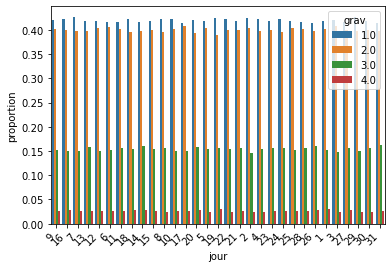

In [38]:
var = "jour"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

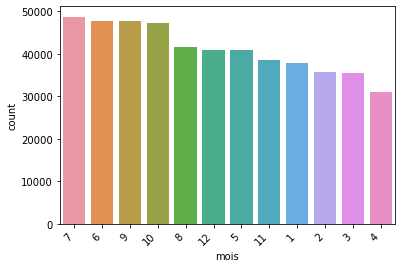

7     48780
6     47731
9     47727
10    47229
8     41632
12    41017
5     40945
11    38659
1     37770
2     35821
3     35515
4     31055
Name: mois, dtype: int64

In [39]:
var = "mois"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()
df_fill_na[var].value_counts()

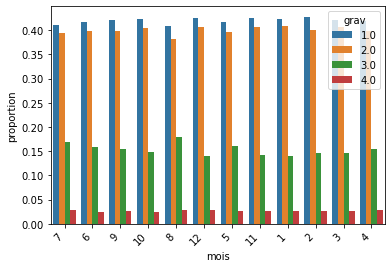

In [40]:
var = "mois"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

## Equipements

### `ceinture` [+++]

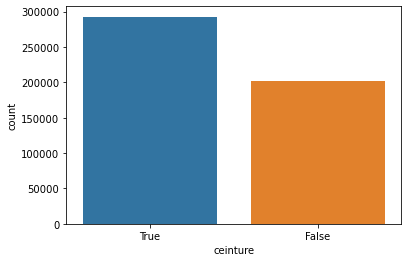

True     292706
False    201175
Name: ceinture, dtype: int64

In [48]:
var = "ceinture"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.show()
df_fill_na[var].value_counts()

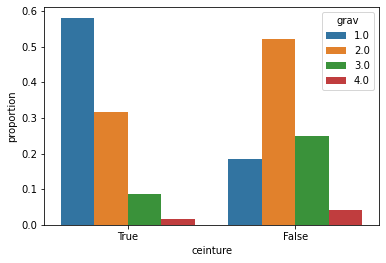

In [49]:
var = "ceinture"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.show()

### `dispositif enfants` [-]

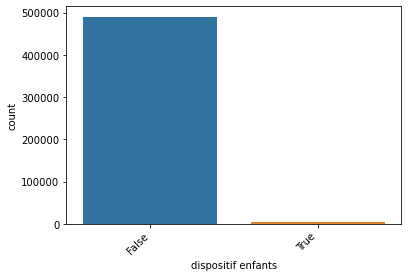

False    490179
True       3702
Name: dispositif enfants, dtype: int64

In [57]:
var = "dispositif enfants"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.show()
df_fill_na[var].value_counts()

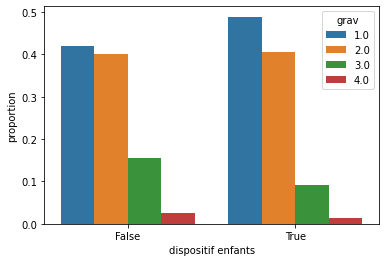

In [58]:
var = "dispositif enfants"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.show()

### `casque` [+++]

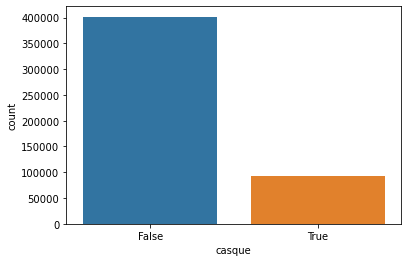

False    401803
True      92078
Name: casque, dtype: int64

In [50]:
var = "casque"
df_fill_na = df_merged.copy()
df_fill_na[var].fillna("nan", inplace=True)
sns.countplot(data=df_fill_na, x=var, order=df_fill_na[var].value_counts().index)
plt.show()
df_fill_na[var].value_counts()

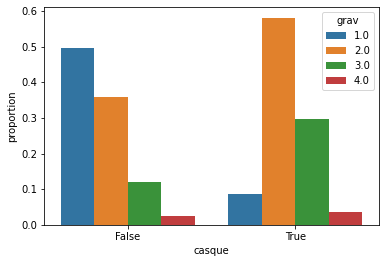

In [51]:
var = "casque"
proportions = df_fill_na.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_fill_na[var].value_counts().index)
plt.show()

# Premiers modèles

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

### MCO

##### binarisation des données en vue de la régression

In [51]:
numeric_features = ["an_nais", "vma"]
categorical_features = ["agg", "catu", "lum_2", "trajet", "sexe", "col_2","secu1","secu2"]


df_mco = df_merged[["grav"] + numeric_features + categorical_features]
df_mco.dropna(inplace=True) 

C:\Users\User\AppData\Local\Temp\ipykernel_15336\3727650300.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mco.dropna(inplace=True)


In [52]:
df_mco

,grav,an_nais,vma,agg,catu,lum_2,trajet,sexe,col_2,secu1,secu2
0,3.0,2008.0,50.0,agglo,conducteur,1,promenade-loisirs,homme,0,2.0,8.0
1,1.0,1948.0,50.0,agglo,conducteur,1,promenade-loisirs,homme,0,1.0,8.0
2,2.0,1988.0,50.0,agglo,conducteur,1,autre,homme,0,1.0,0.0
3,1.0,1970.0,50.0,agglo,conducteur,1,utilisation pro,homme,0,1.0,0.0
5,2.0,1987.0,50.0,agglo,conducteur,1,autre,femme,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
494174,2.0,1968.0,130.0,hors agglo,passager,1,promenade-loisirs,homme,0,1.0,0.0
494175,1.0,1972.0,90.0,hors agglo,conducteur,1,domicile-travail,femme,0,1.0,4.0
494176,2.0,1964.0,90.0,hors agglo,conducteur,1,domicile-travail,homme,0,1.0,4.0
494177,2.0,1988.0,90.0,hors agglo,conducteur,1,domicile-travail,femme,0,1.0,0.0


In [82]:

categorical_columns = ["agg", "catu", "lum_2", "trajet", "sexe", "col_2", "secu1", "secu2"]
df_mco_encode = pd.get_dummies(df_mco, columns=categorical_columns, drop_first=True)  # binarisation des variables catégorielles, on drop pour éviter la colinéarité parfaite  
df_mco_encode.dropna(inplace=True) # élimination des NA crée 
df_mco_encode


,grav,an_nais,vma,agg_hors agglo,catu_passager,catu_piéton,lum_2_1,trajet_courses-achats,trajet_domicile-travail,trajet_domicile-école,...,secu1_9.0,secu2_1.0,secu2_2.0,secu2_3.0,secu2_4.0,secu2_5.0,secu2_6.0,secu2_7.0,secu2_8.0,secu2_9.0
0,3.0,2008.0,50.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.0,1948.0,50.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2.0,1988.0,50.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1970.0,50.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.0,1987.0,50.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494174,2.0,1968.0,130.0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494175,1.0,1972.0,90.0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
494176,2.0,1964.0,90.0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
494177,2.0,1988.0,90.0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
X=df_mco_encode.drop("grav",axis=1)


In [85]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208092 entries, 0 to 494178
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   an_nais                   208092 non-null  float64
 1   vma                       208092 non-null  float64
 2   agg_hors agglo            208092 non-null  uint8  
 3   catu_passager             208092 non-null  uint8  
 4   catu_piéton               208092 non-null  uint8  
 5   lum_2_1                   208092 non-null  uint8  
 6   trajet_courses-achats     208092 non-null  uint8  
 7   trajet_domicile-travail   208092 non-null  uint8  
 8   trajet_domicile-école     208092 non-null  uint8  
 9   trajet_promenade-loisirs  208092 non-null  uint8  
 10  trajet_utilisation pro    208092 non-null  uint8  
 11  sexe_homme                208092 non-null  uint8  
 12  col_2_1                   208092 non-null  uint8  
 13  secu1_1.0                 208092 non-null  u

In [86]:
X=X.dropna()


In [90]:
import statsmodels.api as sm

# Assuming X is your independent variable matrix, and 'grav' is the dependent variable
X = df_mco_encode.drop('grav', axis=1)
y = df_mco_encode['grav']

# Add a constant term to the independent variables matrix
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Display the regression results summary
print(results.summary2())


                     Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.338      
Dependent Variable:    grav              AIC:                 368618.1127
Date:                  2023-12-07 10:09  BIC:                 368945.9762
No. Observations:      208092            Log-Likelihood:      -1.8428e+05
Df Model:              31                F-statistic:         3428.      
Df Residuals:          208060            Prob (F-statistic):  0.00       
R-squared:             0.338             Scale:               0.34417    
-------------------------------------------------------------------------
                          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
const                     2.7173   0.1557  17.4491 0.0000  2.4121  3.0225
an_nais                  -0.0004   0.0001  -5.0171 0.0000 -0.0005 -0.0002
vma                       0.0017   0.0001  17.5444 0.0000  

## KNeighbors #2

In [27]:
numeric_features = ["an_nais", "h", "vma"]
categorical_features = ["agg", "catu", "sexe", "nbv", "trajet", "lum", "col", "manv", "motor", "choc",
                        "catr", "circ", "plan", "situ", "obsm", "ceinture"]

df_relevant = df_merged[["grav"] + numeric_features + categorical_features]

In [28]:
from sklearn.impute import SimpleImputer

X = df_relevant.drop("grav", axis=1)
y = df_relevant["grav"]

# On sépare variables numériques et catégorielles
numeric_data = X[numeric_features]
categorical_data = X[categorical_features]

# On impute les NaN pour les numériques
numeric_imputer = SimpleImputer(strategy='mean')
numeric_data_imputed = pd.DataFrame(numeric_imputer.fit_transform(numeric_data), columns=numeric_features)

# On impute les NaN pour les catégorielles
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = pd.DataFrame(categorical_imputer.fit_transform(categorical_data), columns=categorical_features)

# On concatène tout ça dans X
X = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)

# On modifie X pour avoir des dummies pour les catégorielles
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
for var in numeric_features:
    X[var] = (X[var]-X[var].mean())/X[var].std()

In [29]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.6048574060763133, 0.7237436219324532)

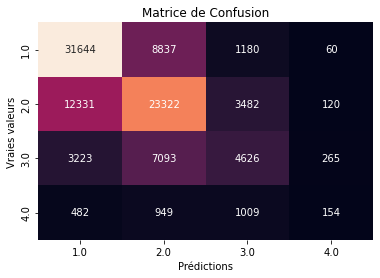

In [31]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

## SVC #2

Trop long à tourner.

In [23]:
numeric_features = ["an_nais", "h", "vma"]
categorical_features = ["agg", "catu", "sexe", "nbv", "trajet", "lum", "col", "manv", "motor", "choc",
                        "catr", "circ", "plan", "situ", "obsm", "ceinture"]

df_relevant = df_merged[["grav"] + numeric_features + categorical_features]

In [24]:
from sklearn.impute import SimpleImputer

X = df_relevant.drop("grav", axis=1)
y = df_relevant["grav"]

# On sépare variables numériques et catégorielles
numeric_data = X[numeric_features]
categorical_data = X[categorical_features]

# On impute les NaN pour les numériques
numeric_imputer = SimpleImputer(strategy='mean')
numeric_data_imputed = pd.DataFrame(numeric_imputer.fit_transform(numeric_data), columns=numeric_features)

# On impute les NaN pour les catégorielles
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = pd.DataFrame(categorical_imputer.fit_transform(categorical_data), columns=categorical_features)

# On concatène tout ça dans X
X = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)

# On modifie X pour avoir des dummies pour les catégorielles
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
for var in numeric_features:
    X[var] = (X[var]-X[var].mean())/X[var].std()

In [25]:
from sklearn.svm import SVC
model = SVC(kernel="linear")

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

## Arbre de décision

In [53]:
numeric_features = ["an_nais", "h", "vma"]
categorical_features = ["agg", "catu", "sexe", "nbv", "trajet", "lum", "col", "manv", "motor", "choc",
                        "catr", "circ", "plan", "situ", "obsm", "ceinture",
                        "casque", "dispositif enfants"]

df_relevant = df_merged[["grav"] + numeric_features + categorical_features]

In [54]:
from sklearn.impute import SimpleImputer

X = df_relevant.drop("grav", axis=1)
y = df_relevant["grav"]

# On sépare variables numériques et catégorielles
numeric_data = X[numeric_features]
categorical_data = X[categorical_features]

# On impute les NaN pour les numériques
numeric_imputer = SimpleImputer(strategy='mean')
numeric_data_imputed = pd.DataFrame(numeric_imputer.fit_transform(numeric_data), columns=numeric_features)

# On impute les NaN pour les catégorielles
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = pd.DataFrame(categorical_imputer.fit_transform(categorical_data), columns=categorical_features)

# On concatène tout ça dans X
X = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)

# On modifie X pour avoir des dummies pour les catégorielles
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
for var in numeric_features:
    X[var] = (X[var]-X[var].mean())/X[var].std()

In [55]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=14)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.6434898812476588, 0.6764573378148538)

Voici les scores en cross-validation.

In [90]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-Validation Scores:", scores)
print(f"Mean Accuracy: {scores.mean():.3f}")

Cross-Validation Scores: [0.63698027 0.63489107 0.63610594 0.63371669 0.63381793]
Mean Accuracy: 0.635


[Text(0.5225409836065574, 0.9166666666666666, 'ceinture_True <= 0.5\ngini = 0.639\nsamples = 395104\nvalue = [165633, 158239, 60779, 10453]'),
 Text(0.26229508196721313, 0.75, 'agg_hors agglo <= 0.5\ngini = 0.628\nsamples = 160953\nvalue = [29562, 84302, 40266, 6823]'),
 Text(0.13114754098360656, 0.5833333333333334, 'catu_piéton <= 0.5\ngini = 0.58\nsamples = 117772\nvalue = [21850, 68969, 24222, 2731]'),
 Text(0.06557377049180328, 0.4166666666666667, 'obsm_piéton <= 0.5\ngini = 0.597\nsamples = 89022\nvalue = [21048, 49801, 16468, 1705]'),
 Text(0.03278688524590164, 0.25, 'motor_hydrocarbures <= 0.5\ngini = 0.568\nsamples = 81326\nvalue = [14609, 48706, 16323, 1688]'),
 Text(0.01639344262295082, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.04918032786885246, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.09836065573770492, 0.25, 'choc_avant <= 0.5\ngini = 0.279\nsamples = 7696\nvalue = [6439, 1095, 145, 17]'),
 Text(0.08196721311475409, 0.08333333333333333, '\n  (...)  \n'),
 Text(0

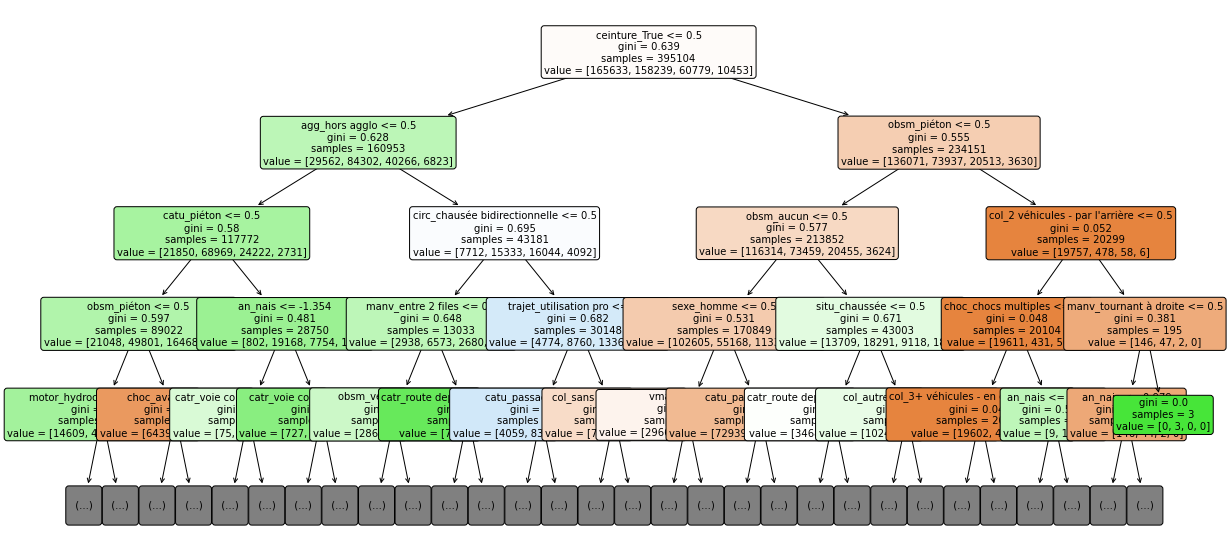

In [91]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, max_depth=4, fontsize=10)

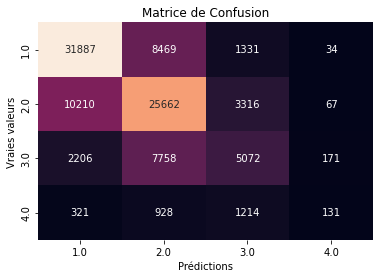

In [92]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

## Forêt aléatoire

In [119]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=30, 
                               max_depth=20, 
                               random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.6510624943053545, 0.7419970438163117)

In [120]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-Validation Scores:", scores)
print(f"Mean Accuracy: {scores.mean():.3f}")

Cross-Validation Scores: [0.65413001 0.65244594 0.65228396 0.65157528 0.65154491]
Mean Accuracy: 0.652


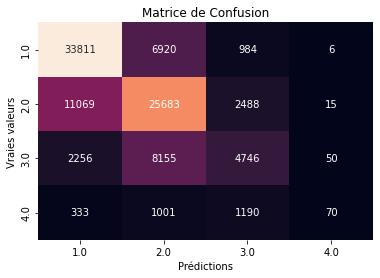

In [121]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()